## Laboratorium 8.2


## Przepływ optyczny i śledzenie obiektów

### Wprowadzenie

Metodę przepływu optycznego (między innymi) można stosować również do śledzenia obiektów. Zazwyczaj wykorzystuje się w tym celu metody rzadkie połączone ze znanymi już nam metodami detekcji punktów zainteresowania. Procedura przebiega podobnie jak w przypadku gęstego przepływu (tzn. operujemy na parze klatek w skali szarości, znajdujemy wektory przesunięć), z tą różnicą że obliczanie przepływu zachodzi wyłącznie dla interesujących nas punktów - a zatem musimy znać ich położenia, aby zainicjować proces. Można sobie wyobrazić różne sposoby zlokalizowania punktów kluczowych, w zależności od konkretnego zastosowania i założeń: być może np. pipeline do przetwarzania rozpoczyna się od detekcji obiektów, a może z góry wiemy, gdzie obiekty się początkowo znajdują.

W OpenCV podstawową metodą do obliczania przepływu dla zbioru punktów jest metoda Lucasa-Kanade, zaimplementowana w funkcji [`cv2.calcOpticalFlowPyrLK`](https://docs.opencv.org/3.4/dc/d6b/group__video__track.html#ga473e4b886d0bcc6b65831eb88ed93323). Podobnie jak w metodzie Farnebacka, argument `nextPts` ustawiamy na `None` (chyba, że chcemy zainicjować rozwiązanie już znanymi położeniami punktów, ale w praktyce z reguły nie będziemy mieli takiej wygody), argumenty `status` i `err` pomijamy zupełnie. W odróżnieniu od Farnebacka, wynikiem są absolutne położenia punktów na drugiej klatce (a nie wektory przesunięć). Dodatkowo otrzymujemy też wektor `status` informujący dla każdego punktu, czy udało się go odnaleźć, oraz `err` mierzący jakąś miarę błędu wizualnego pomiędzy fragmentem obrazu zawierającym dany punkt kluczowy.

Do inicjalizacji rozwiązania można wykorzystać znane nam metody znajdowania punktów kluczowych, albo opartą o detektor Harrisa funkcję [`cv2.goodFeaturesToTrack`](https://docs.opencv.org/3.4/dd/d1a/group__imgproc__feature.html#ga1d6bb77486c8f92d79c8793ad995d541) - jest nieco prostsza w użyciu, bo na wyjściu otrzymujemy po prostu macierz `np.float32` o wymiarach $Nx1x2$ zawierającą koordynaty znalezionych punktów.

Oczywiście, śledzenie obiektów oparte o jednorazową inicjalizację jest narażone na błędy: zniknięcie lub tymczasowe zasłonięcie śledzonego obiektu, czy choćby zmiana jego wyglądu (np. wskutek pojawienia się cienia) mogą spowodować, że przepływ nie zostanie obliczony. Może być też pożądana możliwość śledzenia ciągłego z uwzględnieniem pojawiania się nowych obiektów (np. monitorowanie CCTV). W takich sytuacjach konieczne jest regularne odświeżanie inicjalizacji, tj. ponowne wykrycie interesujących obiektów. To z kolei prowadzi do kolejnego problemu: jeżeli interesuje nas cała historia ruchu danych obiektów, przy czym do pewnego momentu ich lokalizacje uzyskiwaliśmy za pomocą przepływu optycznego, a w pewnym momencie wykonaliśmy ponowną detekcję - to jak powiązać jedno z drugim, by zapewnić ciągłość lokalizacji? To zagadnienie, oraz pozostałe tematy dyskutowane w tym kontekście na wykładzie, nie będzie jednak centralne na laboratorium.

---

### Cel zadania

Celem tej listy jest (1) zapoznanie się z metodą przepływu optycznego rzadkiego do zastosowań śledzenia obiektów, oraz (2) zastosowanie tej techniki w praktyce, na przykładzie monitorowania prędkości obiektu (w metrach na sekundę). Przykładem badawczym będzie nagranie startu Wahadłowca Kosmicznego _Discovery_ (misja [STS-124](https://en.wikipedia.org/wiki/STS-124)), zarejestrowane jedną z kamer technicznych (plik `shuttle.mp4`).

Aby obliczyć prędkość, potrzebna jest znajomość drogi (w metrach) i czasu (w sekundach). Czas między klatkami obliczysz, znając liczbę klatek na sekundę, którą możesz pobrać bezpośrednio z otwartego obiektu `VideoCapture` za pomocą następującej konstrukcji:  
```python
fps = source.get(cv2.CAP_PROP_FPS)
```  
Wyznaczenie przelicznika między przestrzenią obrazu (w pikselach) a przestrzenią świata (w metrach) jest w ogólności [nieco złożonym zagadnieniem](https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html); znalezienie uproszczonej alternatywy jest Twoim zadaniem.

Źródło nagrania: [_"Best of the Best" Provides New Views, Commentary of Shuttle Launches_ (NASA @ YouTube)](https://www.youtube.com/watch?v=vFwqZ4qAUkE), 29:06.5  
Nagranie o oryginalnej prędkości ~225 fps odtwarzane przy typowej prędkości 30fps wyglądałoby na spowolnione w proporcji ok. 1:7.5; zostało zatem przekodowane tak, aby osiągnąć zbieżność upływu czasu 1:1 z rzeczywistym. Możesz się o tym upewnić patrząc na _timestamp_ z prawej strony nagrania ([_jak go czytać_](https://space.stackexchange.com/a/38569)).

In [1]:
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

### Zadanie 1

Na podstawie pierwszej klatki z materiału dokonaj kalibracji parametrów detektora cech do śledzenia (sugerowany detektor: [`cv2.goodFeaturesToTrack`](https://docs.opencv.org/3.4/dd/d1a/group__imgproc__feature.html#ga1d6bb77486c8f92d79c8793ad995d541)). Dobór tych parametrów jest kluczowy dla reszty zadania, więc zapoznaj się z ich znaczeniem i postaraj tak dobrać, by uzyskać odpowiednio dużo (10+) punktów w rejonie śledzonego obiektu.

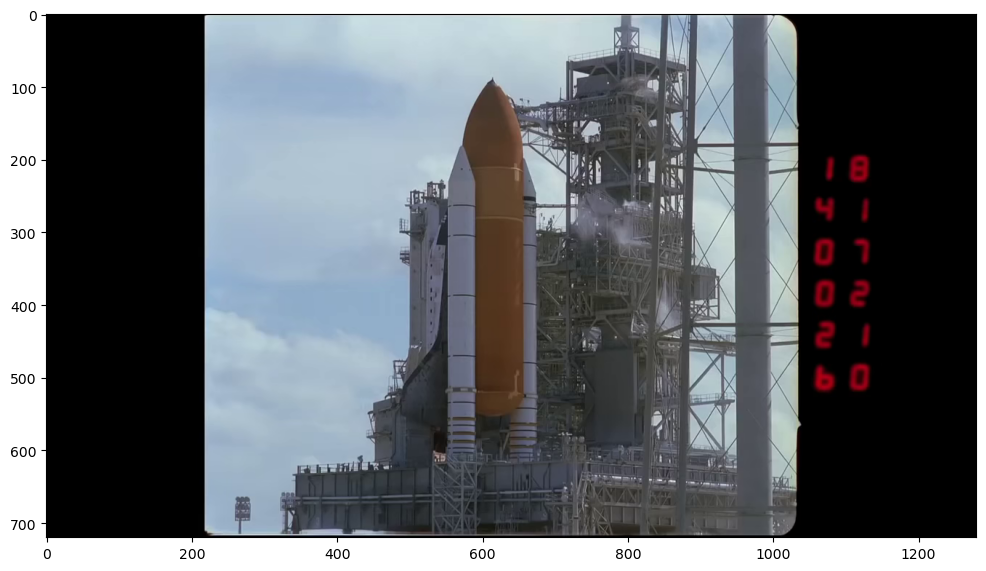

In [2]:
source = cv2.VideoCapture('dane/shuttle.mp4')
status, frame = source.read()
source.release()
plt.subplots(1, 1, figsize=(12,12))[1].imshow(frame[..., ::-1]);

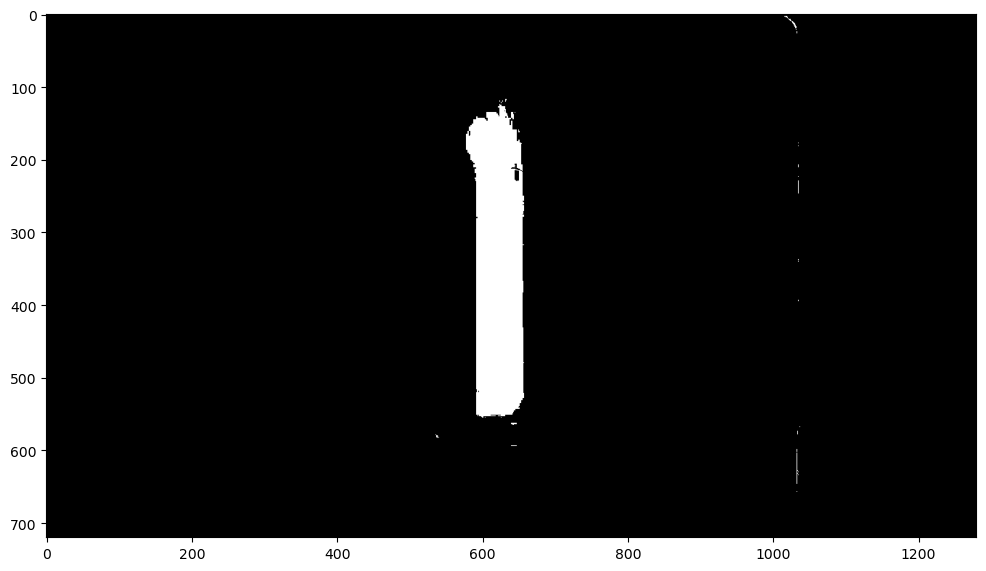

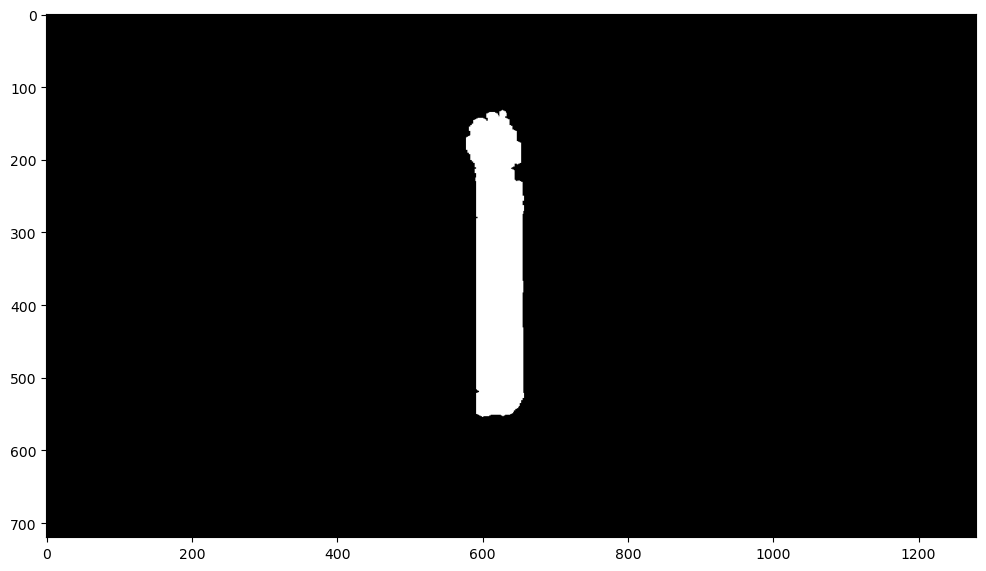

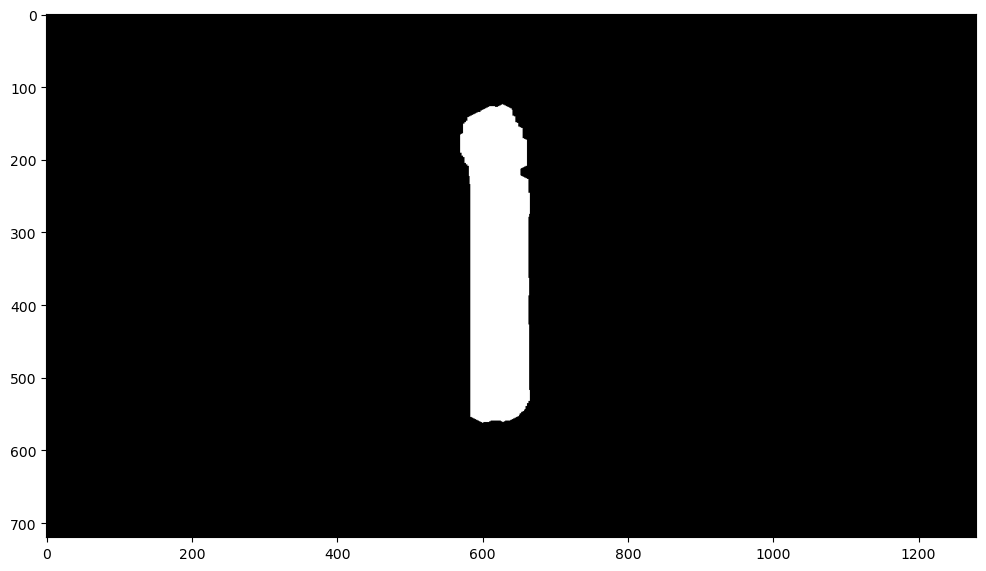

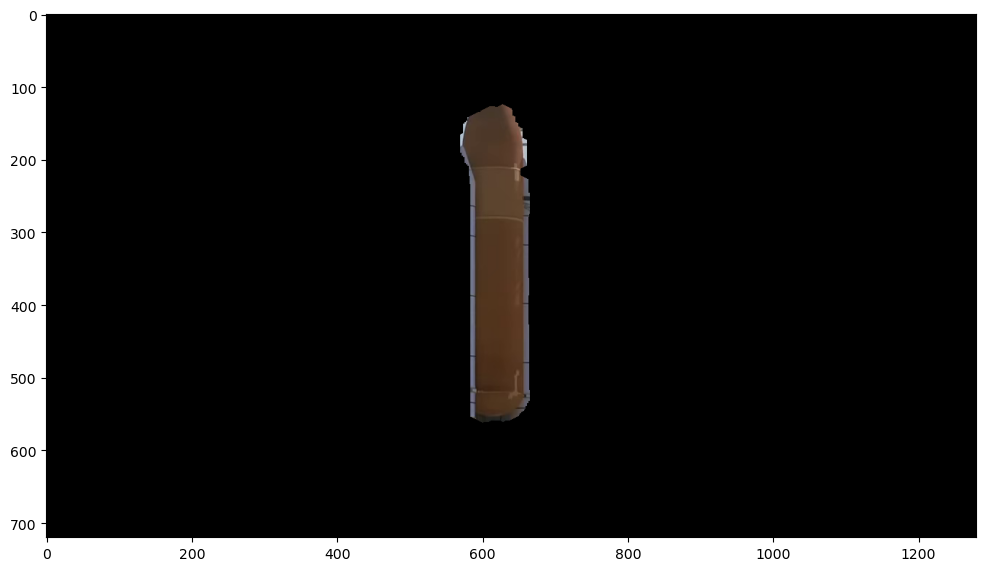

In [3]:
# create a mask of orange pixels
def orange_mask(frame):
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    lower = np.array([10, 100, 20])
    upper = np.array([25, 255, 255])
    mask = cv2.inRange(hsv, lower, upper)
    return mask


original_frame = frame.copy()

mask = orange_mask(frame)
plt.subplots(1, 1, figsize=(12,12))[1].imshow(mask, cmap='gray');

# apply opening to the mask to remove noise

def opening(mask, kernel_size=5):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    return cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=2)

mask_opened = opening(mask)
plt.subplots(1, 1, figsize=(12,12))[1].imshow(mask_opened, cmap='gray');

# apply distilate to show more object pixels

def dilate(mask, kernel_size=5):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    return cv2.dilate(mask, kernel, iterations=4)

mask_dilated = dilate(mask_opened)
plt.subplots(1, 1, figsize=(12,12))[1].imshow(mask_dilated, cmap='gray');

def complete_mask(frame):
    frame = frame.copy()
    mask = orange_mask(frame)
    mask = opening(mask)
    mask = dilate(mask)

    return mask
    


# show original frame with mask applied
def apply_mask(frame, mask):
    return cv2.bitwise_and(frame, frame, mask=mask)

frame = original_frame.copy()

mask_complete = complete_mask(frame)

frame_masked = apply_mask(frame, mask_dilated)
plt.subplots(1, 1, figsize=(12,12))[1].imshow(frame_masked[..., ::-1]);

C:\Users\Konrad\AppData\Local\Temp\ipykernel_34580\1095450865.py:14: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  corners = np.int0(corners)


Number of corners: 11


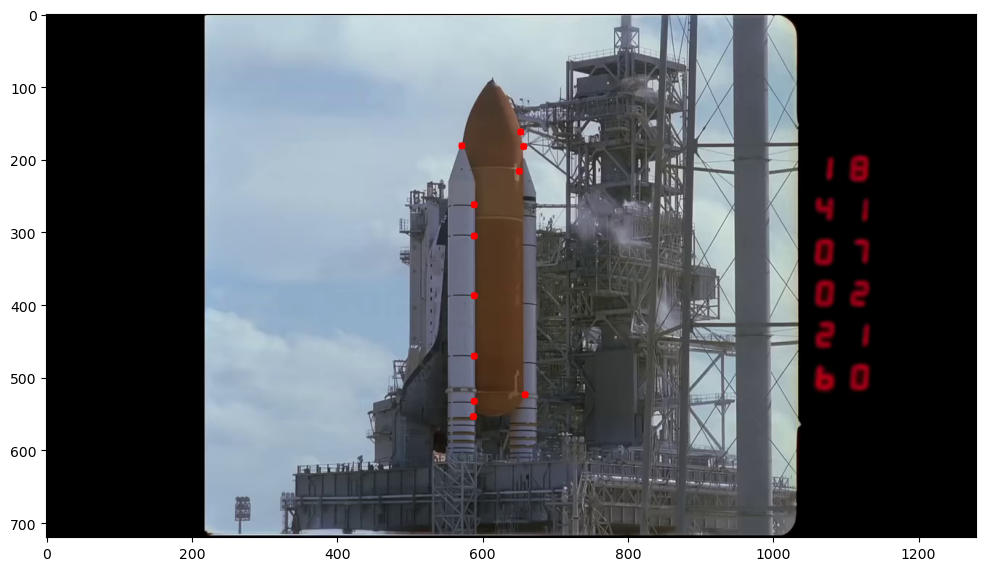

In [4]:
quality = 0.15
min_distance = 20
max_corners = 50


source = cv2.VideoCapture('dane/shuttle.mp4')
status, frame = source.read()

mask = complete_mask(frame)

gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
corners = cv2.goodFeaturesToTrack(gray, max_corners, quality, min_distance, mask=mask)

corners = np.int0(corners)
print(f'Number of corners: {len(corners)}')
for corner in corners:
    x, y = corner.ravel()
    cv2.circle(frame, (x, y), 5, (0, 0, 255), -1)

plt.subplots(1, 1, figsize=(12,12))[1].imshow(frame[..., ::-1]);




### Zadanie 2

Uzupełnij daną poniżej podstawową pętlę analizy wideo o śledzenie obiektów: inicjalizację i wykorzystanie przepływu optycznego do aktualizacji ich położenia. Celem jest pozyskanie pełnej trajektorii pojazdu, tak aby można było ją narysować (np. [`cv2.polylines`](https://docs.opencv.org/3.4/d6/d6e/group__imgproc__draw.html#gaa3c25f9fb764b6bef791bf034f6e26f5)) tudzież przetwarzać dalej.

Zapoznaj się dobrze z dokumentacją funkcji [`cv2.calcOpticalFlowPyrLK`](https://docs.opencv.org/3.4/dc/d6b/group__video__track.html#ga473e4b886d0bcc6b65831eb88ed93323), zwłaszcza z wartościami zwracanymi, **zwłaszcza** `status`. Upewnij się, że odpowiednio obsługujesz przypadki niepowodzenia znalezienia przepływu dla poszczególnych punktów.

Wynik zaprezentuj w postaci graficznej (narysowane trajektorie).

In [5]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

lk_params = dict(
    winSize=(17, 17),
    maxLevel=3,
    criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03),
)

In [6]:
def baseLoopWithAnimation(source: cv2.VideoCapture):
    frames = []
    trajectories = []

    # Read the first frame
    status, frame_next = source.read()
    if not status:
        print("Error: Unable to read video source.")
        return None, None, None

    # Convert the first frame to grayscale
    frame_next_gray = cv2.cvtColor(frame_next, cv2.COLOR_BGR2GRAY)

    # Create the mask and find initial good features to track
    mask = orange_mask(frame_next)
    mask = opening(mask)
    mask = dilate(mask)
    p0 = cv2.goodFeaturesToTrack(frame_next_gray, maxCorners=50, qualityLevel=0.15, minDistance=20, mask=mask)
    

    # Define random colors for the trajectories
    color = np.random.randint(0, 255, (50, 3))

    # Initialize result image for drawing
    result_img = np.zeros_like(frame_next)

    while status:
        frame = frame_next
        frame_gray = frame_next_gray

        # Read the next frame
        status, frame_next = source.read()
        if not status:
            break

        # Convert the next frame to grayscale
        frame_next_gray = cv2.cvtColor(frame_next, cv2.COLOR_BGR2GRAY)

        # If no points to track, break the loop
        if p0 is None:
            break

        # Calculate optical flow
        p1, st, err = cv2.calcOpticalFlowPyrLK(frame_gray, frame_next_gray, p0, None, **lk_params)

        # Select good points
        if p1 is not None:
            good_new = p1[st == 1]
            good_old = p0[st == 1]

            subtrajectories = []
            for i, (new, old) in enumerate(zip(good_new, good_old)):
                a, b = new.ravel()
                c, d = old.ravel()

                # Draw the tracks
                result_img = cv2.line(result_img, (int(c), int(d)), (int(a), int(b)), color[i].tolist(), 2)
                frame_next = cv2.circle(frame_next, (int(a), int(b)), 5, color[i].tolist(), -1)
                subtrajectories.append((a, b, c, d))

            trajectories.append(subtrajectories)

            # Combine the frame with the drawn trajectories
            img = cv2.add(frame_next, result_img)

            # Append the frame for animation
            frames.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

            # Update the points to track
            p0 = good_new.reshape(-1, 1, 2)

    # Release the video source
    source.release()

    # Create animation
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_axis_off()
    im = ax.imshow(frames[0])
    fig.tight_layout()

    def update(frame):
        im.set_array(frame)
        return [im]

    anim = FuncAnimation(fig, update, frames=frames, interval=30, blit=True)
    plt.close(fig)

    return anim, frames, trajectories

# Usage example:
# cap = cv2.VideoCapture("your_video_file.mp4")
# anim, frames, trajectories = baseLoopWithAnimation(cap)
# HTML(anim.to_jshtml())

In [7]:
import matplotlib as mpl
mpl.rcParams['animation.embed_limit'] = 200  # Increase limit


In [ ]:
cap = cv2.VideoCapture("dane/shuttle.mp4")
anim, frames, trajectories = baseLoopWithAnimation(cap)
display(HTML(anim.to_jshtml()))

### Zadanie 3

Dokonaj analizy znalezionych trajektorii i znajdź prędkość _Discovery_.

Wersja minimum: załóż, że pojazd porusza się z lokalnie stałą prędkością.  
Wersja normalna: wykreśl prędkość pojazdu jako funkcję czasu.  
Wersja z plusem: zastosuj odpowiednią filtrację funkcji położenia, by uniezależnić funkcję czasu od szumu.

In [24]:
cap = cv2.VideoCapture("dane/shuttle.mp4")

fps = cap.get(cv2.CAP_PROP_FPS)
print(f"Frames per second using video.get(cv2.CAP_PROP_FPS) : {fps}")

Frames per second using video.get(cv2.CAP_PROP_FPS) : 30.05348189415042


In [25]:
len(trajectories)

359

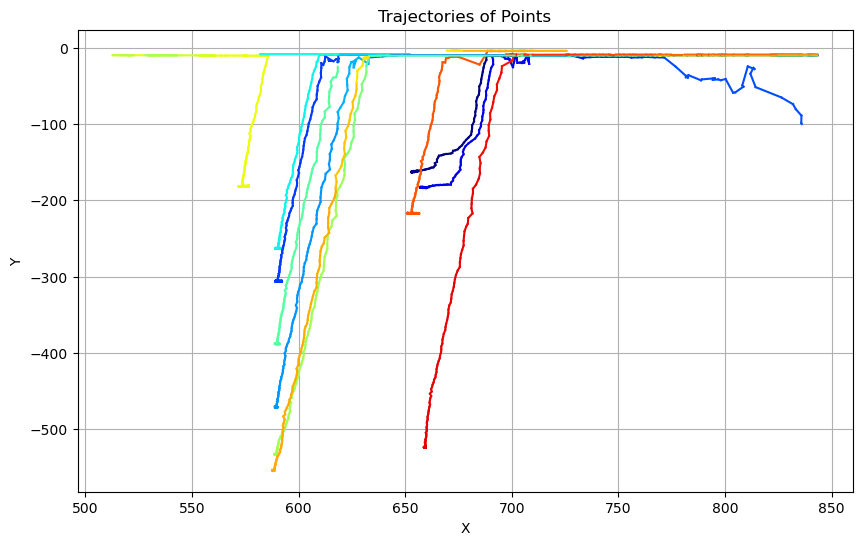

In [26]:
def plot_trajectories(trajectories):
    plt.figure(figsize=(10, 6))
    for frame_trajectories in trajectories:
        for idx, (a, b, c, d) in enumerate(frame_trajectories):
            color = plt.cm.jet(
                idx / len(frame_trajectories)
            )  # Use a colormap for consistent coloring
            plt.plot([a, c], [-b, -d], color=color)
    plt.title("Trajectories of Points")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)
    plt.show()


plot_trajectories(trajectories)

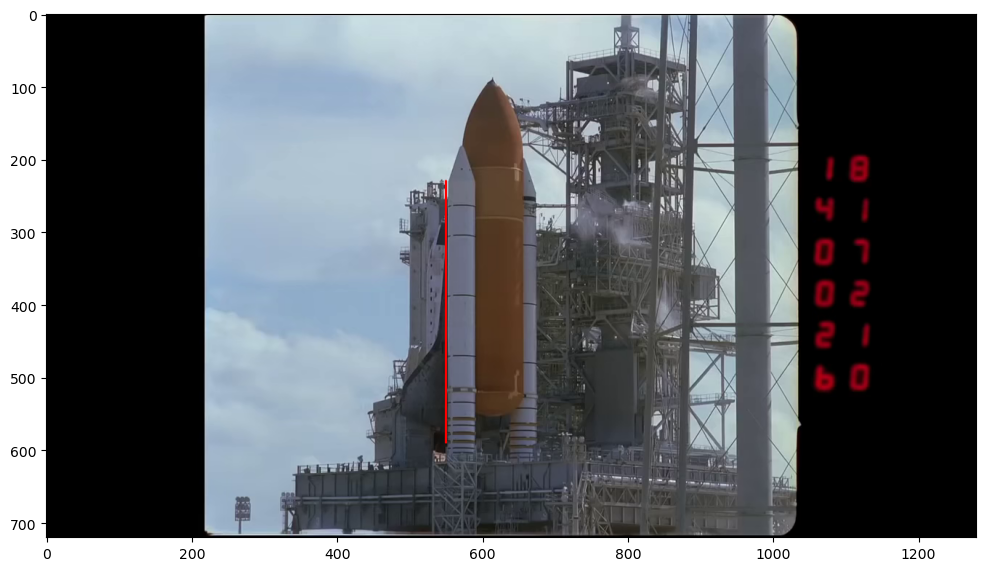

In [27]:
# want to plot a red line between two points ona first frame an set it as 38 meters long, then i want calculate the speed of the shuttle in m/s

source = cv2.VideoCapture("dane/shuttle.mp4")
status, frame = source.read()
source.release()

x1, y1 = 550, 230
x2, y2 = 550, 590

# difference is 38 meters
# distance between two points
distance = np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)

frame = cv2.line(frame, (x1, y1), (x2, y2), (0, 0, 255), 2)
plt.subplots(1, 1, figsize=(12, 12))[1].imshow(frame[..., ::-1])

In [28]:
discovery_length = 38

pixel_to_meter = discovery_length / distance

print(f"1 pixel is equal to {pixel_to_meter} meters")

1 pixel is equal to 0.10555555555555556 meters


In [50]:
video_time = len(frames) / fps
print(f"Video time: {video_time} seconds")

Video time: 11.945371297223149 seconds


In [51]:
def calculate_average_distance(trajectories, pixel_to_meter):
    average_distances = []

    for frame_trajectories in trajectories:
        distances = []
        for a, b, c, d in frame_trajectories:
            distance = np.sqrt((a - c) ** 2 + (b - d) ** 2) * pixel_to_meter
            distances.append(distance)
        average_distance = np.mean(distances) if distances else 0
        average_distances.append(average_distance)

    return average_distances


In [66]:
def plot_average_distance_speed_over_time(average_distances, fps):
    time = np.arange(len(average_distances)) / fps

    speed = np.array(average_distances) * fps

    average_distances = np.cumsum(average_distances)
    


    fig, ax1 = plt.subplots(figsize=(10, 6))

    color = "tab:red"
    ax1.set_xlabel("Time [s]")
    ax1.set_ylabel("Average Distance [m]", color=color)
    ax1.plot(time, average_distances, color=color)
    ax1.tick_params(axis="y", labelcolor=color)

    ax2 = ax1.twinx()
    color = "tab:blue"
    ax2.set_ylabel("Speed [m/s]", color=color)
    ax2.plot(time, speed, color=color)
    ax2.tick_params(axis="y", labelcolor=color)

    fig.tight_layout()  # Otherwise the right y-label is slightly clipped
    plt.title("Average Distance and Speed Over Time")
    plt.grid(True)
    plt.show()

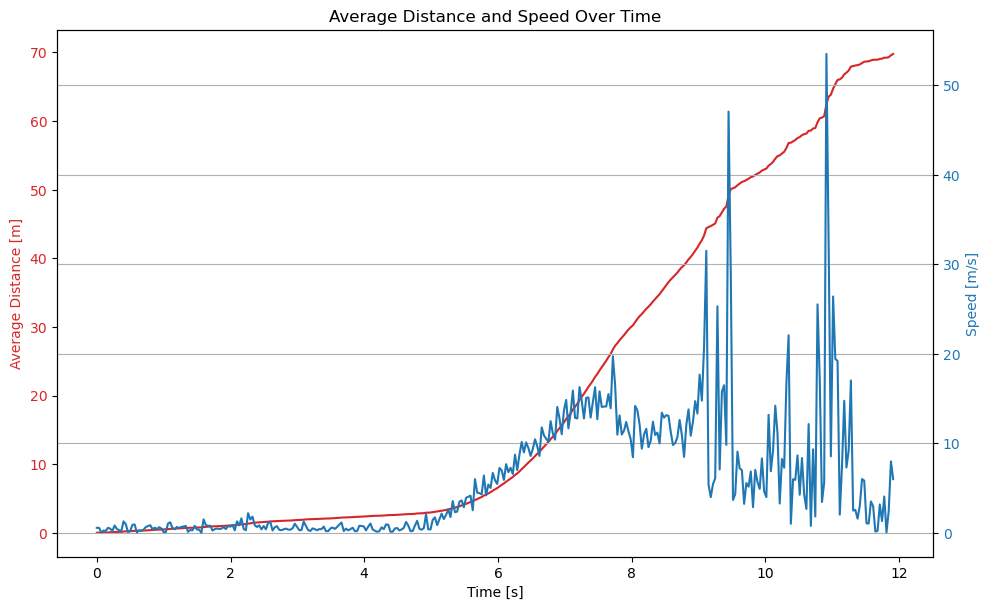

In [67]:
average_distances = calculate_average_distance(trajectories, pixel_to_meter)

plot_average_distance_speed_over_time(average_distances, fps)

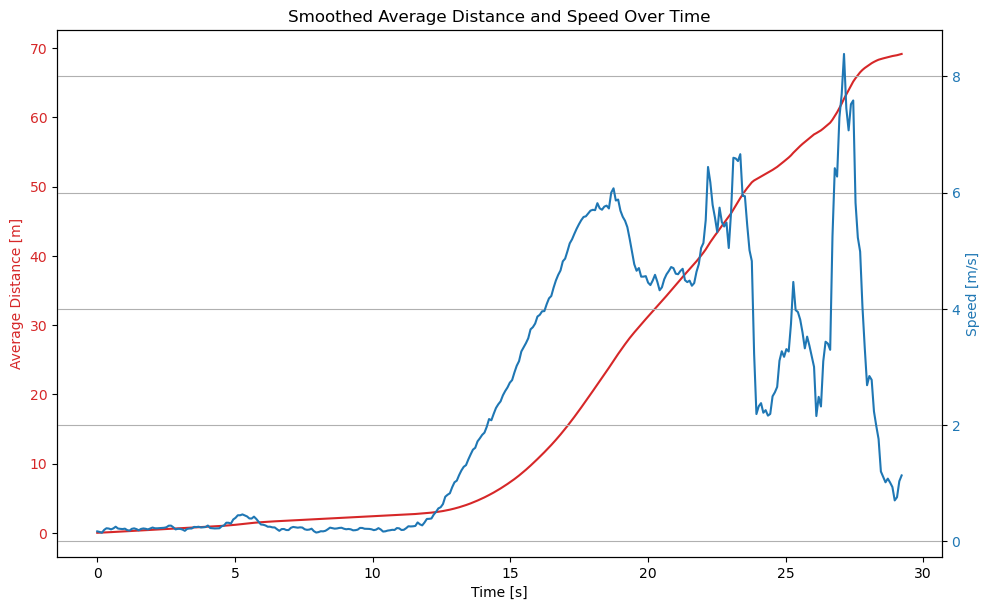

In [71]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode="valid")


def plot_average_distance_speed_over_time_smoothed(average_distances, fps):
    smoothed_average_distances = moving_average(average_distances, 10)
    

    smoothed_speed = np.array(smoothed_average_distances) * fps

    time = np.arange(len(smoothed_average_distances)) / fps

    smoothed_average_distances = np.cumsum(smoothed_average_distances)
    # smoothed_speed = np.insert(smoothed_speed, 0, 0)

    fig, ax1 = plt.subplots(figsize=(10, 6))

    color = "tab:red"
    ax1.set_xlabel("Time [s]")
    ax1.set_ylabel("Average Distance [m]", color=color)
    ax1.plot(time, smoothed_average_distances, color=color)
    ax1.tick_params(axis="y", labelcolor=color)

    ax2 = ax1.twinx()
    color = "tab:blue"
    ax2.set_ylabel("Speed [m/s]", color=color)
    ax2.plot(time, smoothed_speed, color=color)
    ax2.tick_params(axis="y", labelcolor=color)

    fig.tight_layout()  # Otherwise the right y-label is slightly clipped
    plt.title("Smoothed Average Distance and Speed Over Time")
    plt.grid(True)
    plt.show()


plot_average_distance_speed_over_time_smoothed(average_distances, video_time)